In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [76]:
# read in the data with risk scores
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')
risks = pd.read_csv("../data/EDIndex20221202.csv")

In [77]:
edges = edges.merge(risks[['from', 'to', 'index']], left_on=['from', 'to'], right_on=['from', 'to'], how='left')
edges.head()

,from,to,l,h,time,timeU,timeUCB,border,index
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0,40.518729
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0,34.595838
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0,29.757905
3,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0,32.325426
4,8211,1054396,50.646909,primary,75.970364,90.055660,90.055660,0,21.123829


In [78]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB', 'index'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

In [6]:
lengths = []
components = list()

# the same percolation process but this time using the risk scores
for i in np.arange(0, 100):
    G_ = G.copy()
    _ = [G_.remove_edge(u, v) for u, v, d in G.edges(data=True) if d['index'] > i]
    
    labels = pd.DataFrame({u: i for i, n in enumerate(sorted(nx.connected_components(G_), key=len, reverse=True)) for u in n}, index=['component']).T
    labels['threshold'] = i
    labels['gcc'] = len(max(nx.connected_components(G_), key=len))
    
    lengths.append(len(max(nx.connected_components(G_), key=len)))
    components.append(labels)
    
components = pd.concat(components)
components.head()

,component,threshold,gcc
8211,0,0,1
2333,1,0,1
1000559,2,0,1
1000567,3,0,1
5425,4,0,1


In [13]:
def clean_components(dataframe, nodes=nodes, edges=edges, steps=np.arange(0, 100)):
    edges_copy = edges.copy()
    nodes_copy = nodes.copy()

    components_copy = dataframe[dataframe.threshold.isin(steps)].merge(nodes_copy,
                                                                                   left_index=True, right_on='Agglomeration_ID', how='left')


    components_copy['aggnm'] = components_copy['agglosName']
    components_copy['pop15'] = components_copy['Pop2015']
    components_copy['thrno'] = components_copy['threshold']
    components_copy['thrid'] = components_copy['threshold'].astype(int).astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['comid'] = components_copy['component'].astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['aggid'] = components_copy['Agglomeration_ID'].astype(str).str.pad(fillchar="0", side='left', width=7)

    components_copy = components_copy[['aggnm', 'pop15', 'thrno', 'thrid', 'comid', 'aggid', 'gcc', 'Agglomeration_ID']]

    biggest = components_copy.sort_values('pop15', ascending=False).groupby(['thrid', 'comid'], as_index=False).first()
    biggest['biggest_rank'] = biggest.pop15.rank(ascending=False, method='dense')
    n_comps = components_copy[components_copy['aggnm']!='road'].groupby(['thrid', 'comid'], as_index=False).agg({'pop15': ['count', 'sum']})
    n_comps.columns = [''.join(x) for x in n_comps.columns]
    
    components_copy = components_copy.merge(biggest[['thrid', 'comid', 'aggnm', 'pop15', 'biggest_rank']].rename(columns={'aggnm': 'biggest_city', 'pop15': 'biggest_pop'}), 
                                            left_on=['thrid', 'comid'], 
                                            right_on=['thrid', 'comid'], 
                                            how='left').merge(n_comps, 
                                                              left_on=['thrid', 'comid'], 
                                                              right_on=['thrid', 'comid'], 
                                                              how='left').sort_values('pop15count', ascending=False)
    
    return components_copy

def get_color(x):
    # rank the components by count where last place is just the next number in the sequence
    comp_pal = x.groupby(['thrid', 'comid'], as_index=False).agg({'Agglomeration_ID': 'count', 'pop15': 'sum'}).sort_values('pop15', ascending=False)
    comp_pal['rank'] = comp_pal['Agglomeration_ID'].rank(ascending=False, method='min')

    # assign the highest rank #7c7c7c, all the lowest rank #00cff9: we are highlighting the isolates here
    comp_pal['color'] = np.where(comp_pal['rank']==1, '#7c7c7c', '#00cff9')
    
    # merge the colors back to the components
    x = x.merge(comp_pal[['comid', 'color']], left_on='comid', right_on='comid', how='left')
    return x

In [8]:
components = clean_components(components)

In [12]:
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]
africa = africa[africa['iso_a3']!= 'MDG']

Let's map the spread of isolates in the network as risk increases and monitor the size of the connected component as we go.

Text(143.5, 0.5, 'GCC (nodes)')

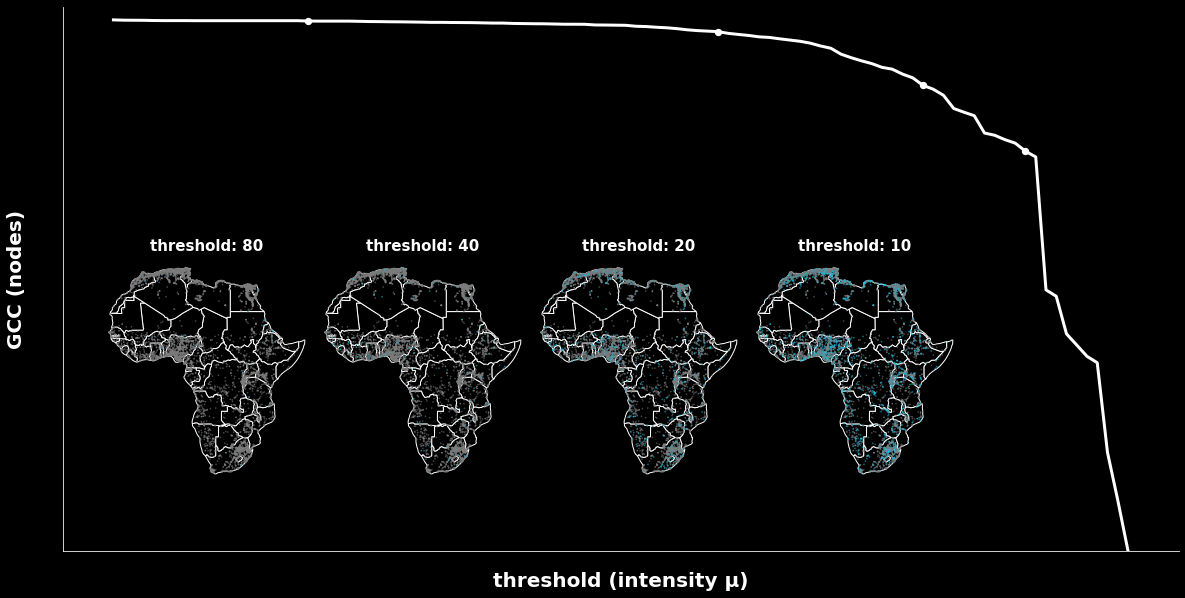

In [26]:
size = [0.15, 0.35]

selection = [80, 40, 20, 10]
points = components[components.thrno.isin(selection)].groupby('thrno').first().reset_index()

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')

ax.plot(np.arange(0, 100), lengths, linewidth=3, color='w')

for i, j in zip(selection, [[0.15, 0.2], [0.3, 0.2], [0.45, 0.2], [0.6, 0.2], [0.75, 0.2]]):
    
    sub = plt.axes(j + size, facecolor='k')
    
    temp_comps = components[components['thrno']==i]
    # print(temp_comps.shape)
    temp_comps = get_color(temp_comps)

    g = temp_comps.gcc.iloc[0]

    africa.plot(color='k', edgecolor='w', linewidth=1, alpha=1, ax=sub)

    temp_nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
    temp_nodes = temp_nodes.merge(temp_comps, left_on='Agglomeration_ID', right_on='Agglomeration_ID')
    temp_nodes['component'] = temp_nodes['biggest_rank']
    
    temp_marks = np.sqrt(temp_nodes['Pop2015'] / 10**4)
    temp_nodes.sort_values('color').plot(color=temp_nodes['color'], markersize=0.5, alpha=0.5, ax=sub)
    sub.set_title(f"threshold: {i}", color='w', weight='bold', size = 15)
    # sub.set_title(f"threshold: {i} | GCC: {temp_comps.gcc.iloc[0]}", color='k', weight='bold', size = 5)
    sub.set_axis_off()
    
ax.scatter(points.thrno.to_numpy(), points.gcc.to_numpy(), s=40, c='w')

ax.invert_xaxis()
ax.set_ylim(0, 7.5 * 10**3)

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='k')
ax.tick_params(axis='y', colors='k')

mu = "intensity " + u"\u03BC"

ax.set_xlabel(f"threshold ({mu})", color="w", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="w", fontdict=font)

Now let's look at possible risks if violence cascades from one place to another. We'll set up a function where we select an area for a cascading event.

In [79]:
# create geodataframe with x,y in nodes data
# nodes.drop(columns=['geometry'], inplace=True)
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.x, nodes.y), crs="EPSG:4326")
nodes = nodes.to_crs("EPSG:3857")

# add columns for the x and y coordinates
nodes['X_'] = nodes.geometry.x
nodes['Y_'] = nodes.geometry.y

In [80]:
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(nodes[['X_', 'Y_']]))
distances = [np.where(i < 10**5)[0] for i in distances]

In [81]:
nodes.reset_index(inplace=True)

In [82]:
def get_cuts(edges, nodes, distances=distances):
    # randomly sample an edge according to the risk
    test = edges.sample(n=1, weights='risk')
    seed = (test.source.values[0], test.target.values[0])
    test = nodes[(nodes['Agglomeration_ID']==test.source.values[0])|(nodes['Agglomeration_ID']==test.target.values[0])]

    # get the indices of the source and target nodes
    set_1 = set(distances[test.index.values[0]])
    set_2 = set(distances[test.index.values[1]])

    # get the union of the two sets
    set_u = set_1.union(set_2)

    # get all edges with u or v in the set
    adjacent = edges[(edges.source.isin(set_u))|(edges.target.isin(set_u))]
    adjacent = adjacent[adjacent['risk'] > 0]

    if adjacent.shape[0] > 0:
        # randomly select a number between 0 and 1 and see if the risk is greater than that number
        adjacent = adjacent[adjacent.risk > np.random.uniform(0, 1)]

        # convert source, target columns to source, target pairs
        adjacent = adjacent[['source', 'target']].values

        # convert to list of tuples
        adjacent = [tuple(x) for x in adjacent if tuple(x) != seed]
        adjacent.append(seed)
    else:
        adjacent = [(seed)]

    return adjacent

In [83]:
x = []
y = []
z = []

Ei = edges.rename(columns={'index': 'risk', 'from': 'source', 'to': 'target'})
Ei['risk'] = Ei['risk'] / Ei['risk'].max()

# convert joined to graph from edgelist
Gi = nx.from_pandas_edgelist(Ei, source='source', target='target', edge_attr='risk')

Ni = nodes.copy()
Ni = nodes.set_index('Agglomeration_ID')

# toggle this number if you want it to run faster, but we want a good sample
for i in np.arange(0, 10000):
    G_ = Gi.copy()
    cuts = get_cuts(Ei, nodes)
    _ = [G_.remove_edge(j[0], j[1]) for j in cuts]

    # get the regions for each isolate
    region_i = [Ni.loc[j, 'Region'] for j in nx.isolates(G_)]
    # get the modal region, unless there are no isolates, in which case return nan
    if len(region_i) == 0:
        region_i = np.nan
    else:
        region_i = max(set(region_i), key=region_i.count)

    # count the number of isolates in the graph
    x.append(len(list(nx.isolates(G_))))
    y.append(sum([Ni.loc[j, 'Pop2015'] for j in nx.isolates(G_)]))
    z.append(region_i)


,from,to,l,h,time,timeU,timeUCB,border,index,Agglomeration_ID,from_region,from_geometry
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0,40.518729,8211,South,POINT (2099040.318 -4041430.924)
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0,34.595838,8211,South,POINT (2099040.318 -4041430.924)
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0,29.757905,8211,South,POINT (2099040.318 -4041430.924)
3,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0,32.325426,8211,South,POINT (2099040.318 -4041430.924)
4,8211,1054396,50.646909,primary,75.970364,90.055660,90.055660,0,21.123829,8211,South,POINT (2099040.318 -4041430.924)
...,...,...,...,...,...,...,...,...,...,...,...,...
9154,6105,122,1.712707,added,6.850830,23.342912,23.342912,0,0.809021,6105,North,POINT (3480588.191 3613212.224)
9155,8397,7392,2.193771,added,8.775085,22.311298,22.311298,0,0.292492,8397,North,POINT (3433429.648 3391221.924)
9156,1441495,1441499,3.754554,added,15.018216,15.018216,15.018216,0,0.057316,1441495,North,POINT (3614911.432 3000617.090)
9157,1441633,7791,2.033237,added,8.132948,15.085325,15.085325,0,1.305709,1441633,North,POINT (3603777.657 3566561.974)


In [110]:
# make a reference map for the regions
from shapely.geometry import Point, LineString
gdf = edges.merge(nodes[['Agglomeration_ID', 'Region', 'geometry']], left_on='from', right_on='Agglomeration_ID', how='left').rename(columns={'geometry':'from_geometry', 'Region':'from_region'})
gdf = gdf.merge(nodes[['Agglomeration_ID', 'Region', 'geometry']], left_on='to', right_on='Agglomeration_ID', how='left').rename(columns={'geometry':'to_geometry', 'Region':'to_region'})
gdf['geometry'] = gdf.apply(lambda x: LineString([x['from_geometry'], x['to_geometry']]), axis=1)
gdf['crossing'] = gdf['from_region'] != gdf['to_region']

region = []

for i, row in gdf.iterrows():
    if row['crossing']: 
        region = np.append(region, "crossing")
    else: 
        region = np.append(region, row['from_region'])

gdf['region'] = region

# convert to geodataframe
gdf = gpd.GeoDataFrame(gdf[['from', 'to', 'region', 'geometry']], crs='epsg:3857')

/Users/asr/opt/anaconda3/envs/locomizer/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Text(0.68, 0.61, 'iteration')

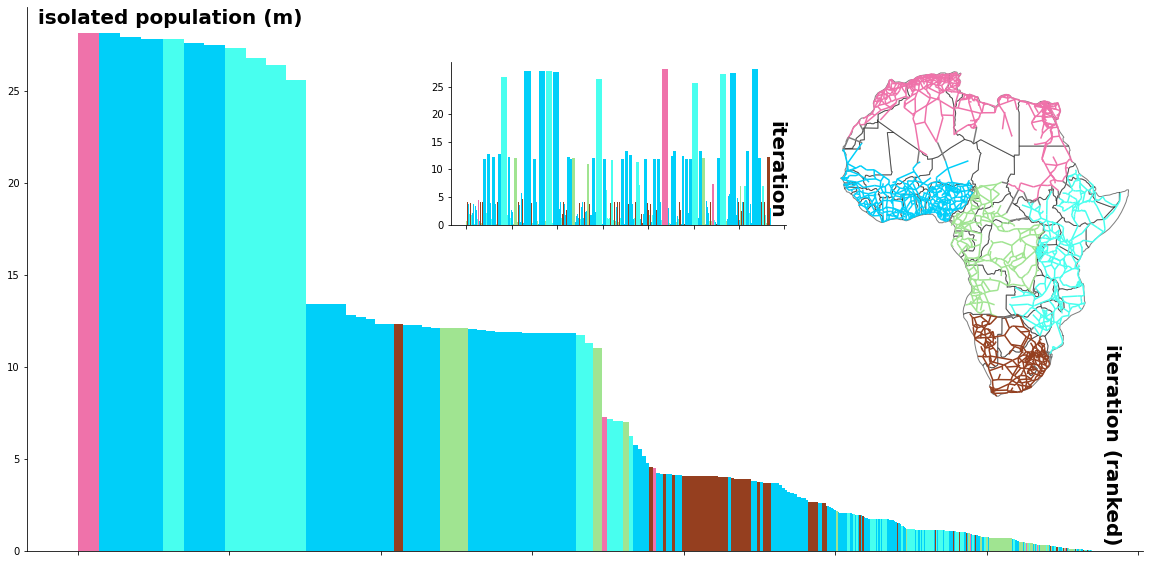

In [113]:

reg2col = {
    'region': ['Central', 'East', 'North', 'South', 'West', 'crossing', 'nan'],
    'color': ['#a0e491', '#48ffef', '#ef72aa', '#953f1f', '#00cff9', '#7c7c7c', '#ffffff']
}

reg2col = dict(zip(reg2col['region'], reg2col['color']))

# sort x by the number of isolates
x = np.array(x)
y = np.array(y)
z = np.array(z)
x_sorted = x[np.argsort(y)]
y_sorted = y[np.argsort(y)]
z_sorted = z[np.argsort(y)]

# reverse these arrays
x_sorted = x_sorted[::-1]
y_sorted = y_sorted[::-1]
z_sorted = z_sorted[::-1]

xticks=[]
for n, c in enumerate(np.arange(0, 10000)):
    xticks.append(sum(y_sorted[:n]) + y_sorted[n]/2)

# make a barchart of lengths
fig, ax = plt.subplots(figsize=(20, 10), facecolor='w')
ax.bar(xticks, y_sorted, color=[reg2col.get(i) for i in z_sorted], width=y_sorted)

# # make x axis tickets every 100
# ax.set_xticks(np.arange(0, 1100, 100))

# add a title
# ax.set_title('Number of Isolates in the Network', size=20, weight='bold')
ax.text(0.01, 0.97, 'isolated population (m)', transform=ax.transAxes, size=20, weight='bold')
# add text in the lower right for the iteration number
ax.text(0.98, 0.01, 'iteration (ranked)', transform=ax.transAxes, size=20, weight='bold', rotation=270, ha='right', va='bottom')

# remove the right and top splines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# import ticker
import matplotlib.ticker as ticker

# divide axis labels by 1000
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))

# remove x labels
ax.set_xticklabels([])

# inset map
map = plt.axes([0.68, 0.3] + [0.22, 0.53], facecolor='#ffffff')
africa[africa['iso_a3']!= 'MDG'].to_crs('EPSG:3857').plot(color='w', edgecolor='k', linewidth=1, alpha=0.5, ax=map)
gdf.plot(color=[reg2col.get(i) for i in gdf.region], ax=map)
map.set_axis_off()

# inset
axins = ax.inset_axes([0.38, 0.6, 0.3, 0.3])
xticks=[]
for n, c in enumerate(np.arange(0, 10000)):
    xticks.append(sum(y[:n]) + y[n]/2)

axins.bar(xticks, y, color=[reg2col.get(i) for i in z], width=y)

# remove the right and top splines
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6)))
axins.set_xticklabels([])

# labels
axins.text(0.68, 0.61, 'iteration', transform=ax.transAxes, size=20, weight='bold', rotation=270, ha='right', va='bottom')